# Covid Data Analysis with Time series and Linear Regression

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings("ignore")

In [2]:
test = pd.read_csv('./Datasets-week-4/test.csv')
train = pd.read_csv('./Datasets-week-4/train.csv')

In [3]:
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.000,0.000
1,2,NaN,Afghanistan,2020-01-23,0.000,0.000
2,3,NaN,Afghanistan,2020-01-24,0.000,0.000
3,4,NaN,Afghanistan,2020-01-25,0.000,0.000
4,5,NaN,Afghanistan,2020-01-26,0.000,0.000


In [4]:
train.columns = ['id', 'state', 'country', 'date', 'cases', 'deaths']

In [5]:
print(train.date.nunique())
print(train.date.min(), train.date.max())

97
2020-01-22 2020-04-27


### Find out top 20 countries having most number of cases for analysis

In [6]:
total_cases = train\
                .groupby(['date', 'country'])\
                .agg({'cases': 'sum', 'deaths': 'sum'})\
                .reset_index()\
                .sort_values('date', ascending=False)\
                .groupby('country')\
                .head(1)

In [7]:
total_cases

,date,country,cases,deaths
17847,2020-04-27,Zimbabwe,32.000,4.000
17721,2020-04-27,Eswatini,65.000,1.000
17730,2020-04-27,Ghana,1550.000,11.000
17729,2020-04-27,Germany,158758.000,6126.000
17728,2020-04-27,Georgia,497.000,6.000
...,...,...,...,...
17786,2020-04-27,Nicaragua,13.000,3.000
17785,2020-04-27,New Zealand,1472.000,19.000
17784,2020-04-27,Netherlands,38440.000,4534.000
17783,2020-04-27,Nepal,52.000,0.000


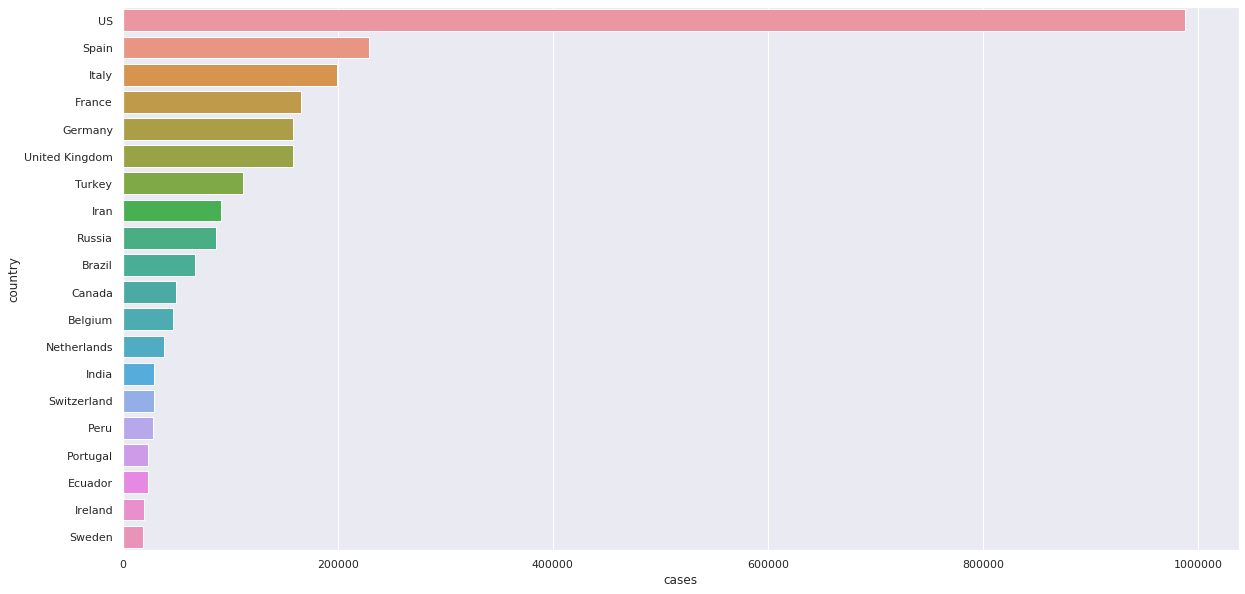

In [8]:
top_20_cases = total_cases[total_cases.country!='China'].sort_values('cases', ascending=False)[:20]
plt.figure(figsize=(20, 10))
sns.barplot(top_20_cases['cases'], top_20_cases['country'])

In [9]:
non_china = train[train.country!='China']
top_20_train = non_china[non_china.country.isin(top_20_cases.country)]
top_20_train.reset_index(drop=True, inplace=True)
top_20_train = top_20_train.groupby(['country', 'date']).agg({'cases': 'sum', 'deaths': 'sum'})
top_20_train.reset_index(inplace=True)

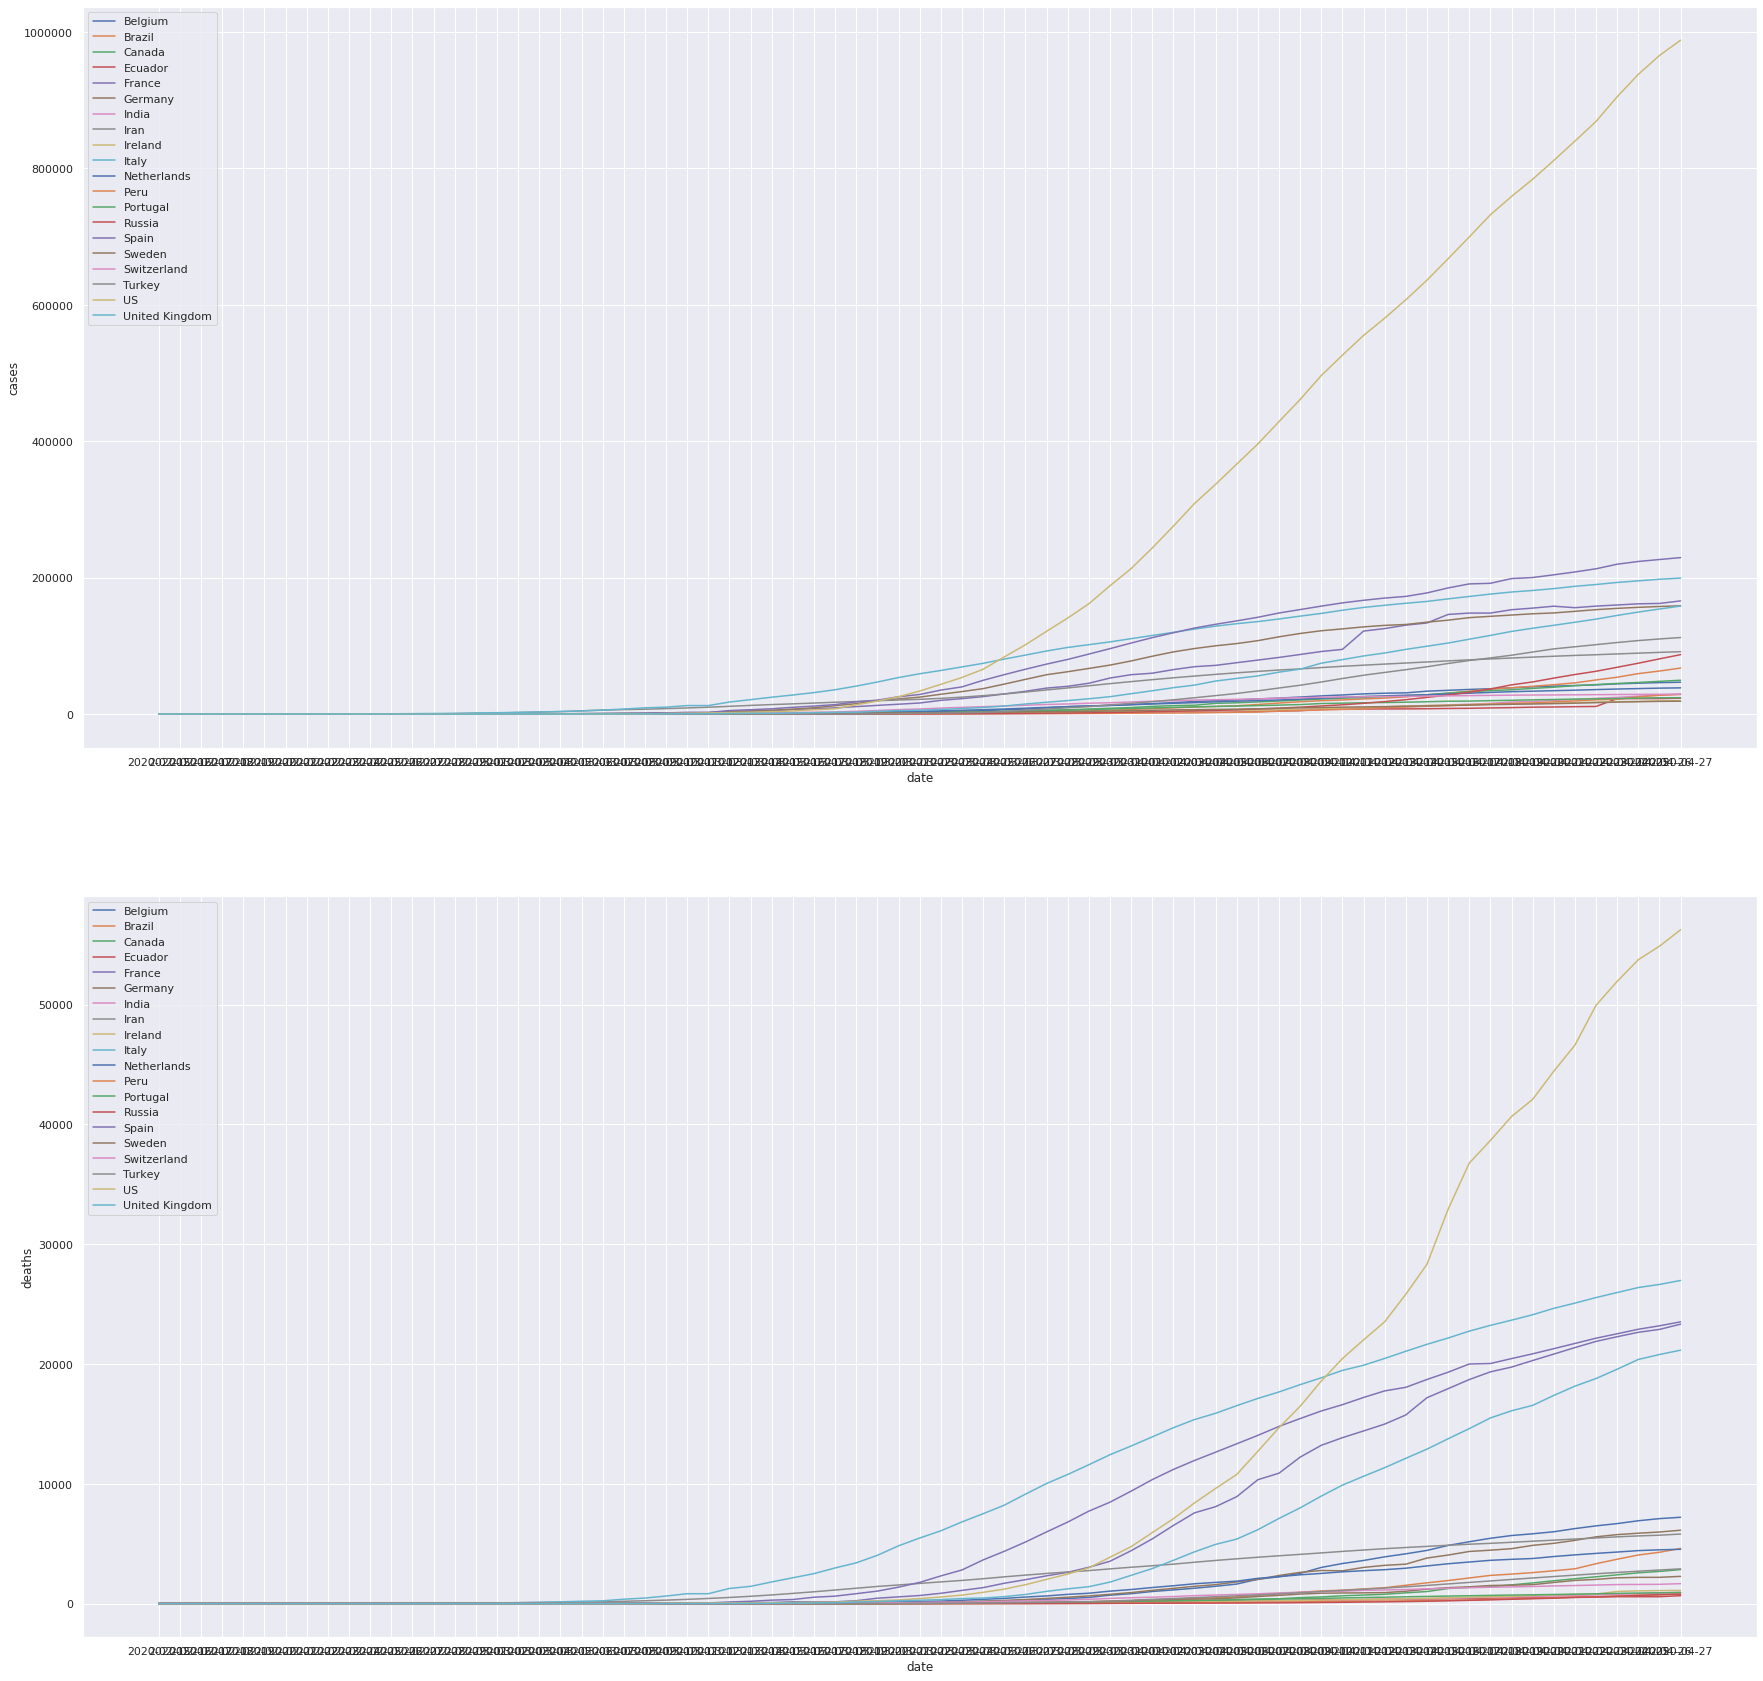

In [10]:
min_date = top_20_train[top_20_train.deaths==1].date.min()

fig, ax = plt.subplots(2, 1, figsize=(30, 30))
for country in top_20_train['country'].unique():
    country_data = top_20_train[top_20_train.country==country]
    country_data = country_data[country_data.date >= min_date]
    sns.lineplot(x='date', y='cases', data=country_data, label=country, ax=ax[0])
    sns.lineplot(x='date', y='deaths', data=country_data, label=country, ax=ax[1])

## Add lags and shifts which will be usefull for time series analysis and prediction

In [11]:
lags = [1, 3, 7]
for lag in lags:
    top_20_train.sort_values(['country', 'date'])
    top_20_train[f'cases_lag_{lag}'] = top_20_train['cases'].diff(lag)
    top_20_train[f'deaths_lag_{lag}'] = top_20_train['deaths'].diff(lag)
    top_20_train[f'cases_shifted_{lag}'] = top_20_train['cases'].shift(lag)
    top_20_train[f'deaths_shifted_{lag}'] = top_20_train['deaths'].shift(lag)

In [12]:
max_null_date = top_20_train[top_20_train.cases_lag_7.isnull()].date.max()
top_20_train = top_20_train[top_20_train.date > max_null_date]

### Construct a new feature 'Growth Rate'  which gives the idea of current growth

In [13]:
def get_cases_growth_rate(row):
    if row.cases == 0.0:
        return 0.0
    return (row.cases_lag_1*0.5 + row.cases_lag_3*0.3 + row.cases_lag_7*0.2) / row.cases

top_20_train['cases_growth_rate'] = top_20_train.apply(get_cases_growth_rate, axis=1)

In [14]:
def get_deaths_growth_rate(row):
    if row.deaths == 0.0:
        return 0.0
    return (row.deaths_lag_1*0.5 + row.deaths_lag_3*0.3 + row.deaths_lag_7*0.2) / row.deaths

top_20_train['deaths_growth_rate'] = top_20_train.apply(get_deaths_growth_rate, axis=1)

Countries like Russia, Peru, Ecaudor seem to be on the rise with high growth rate, so can expect large number of cases in the upcoming days

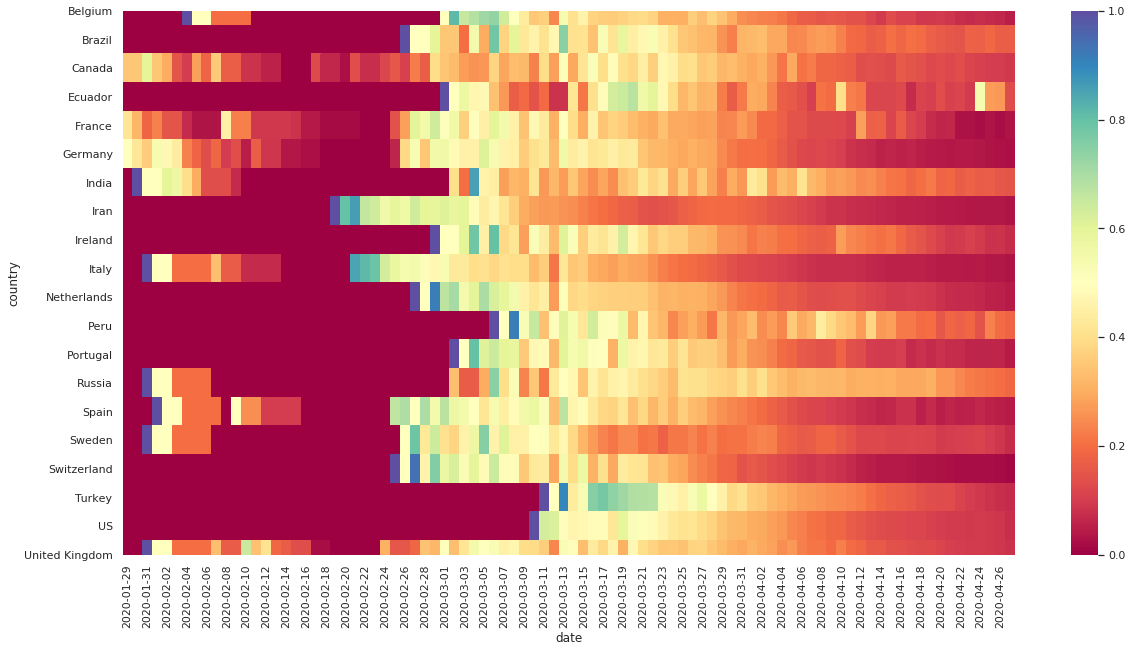

In [15]:
fig = plt.figure(figsize=(20, 10))
top_20_pivot = top_20_train.pivot('country', 'date', 'cases_growth_rate')
sns.heatmap(top_20_pivot, cmap="Spectral")

The graphs also provide same conclusion as heat map above about the countries where the growth rate seems to be high and unpredictable meaning the country is in early stage of virus and it is expected to rise(Ecaudor, India, Peru, Brazil) whereas in other countries the growth rate seems to have settled around 0.1(US, UK, Germany, etc) meaning the number of cases are constantly going to grow with that factor for near future.

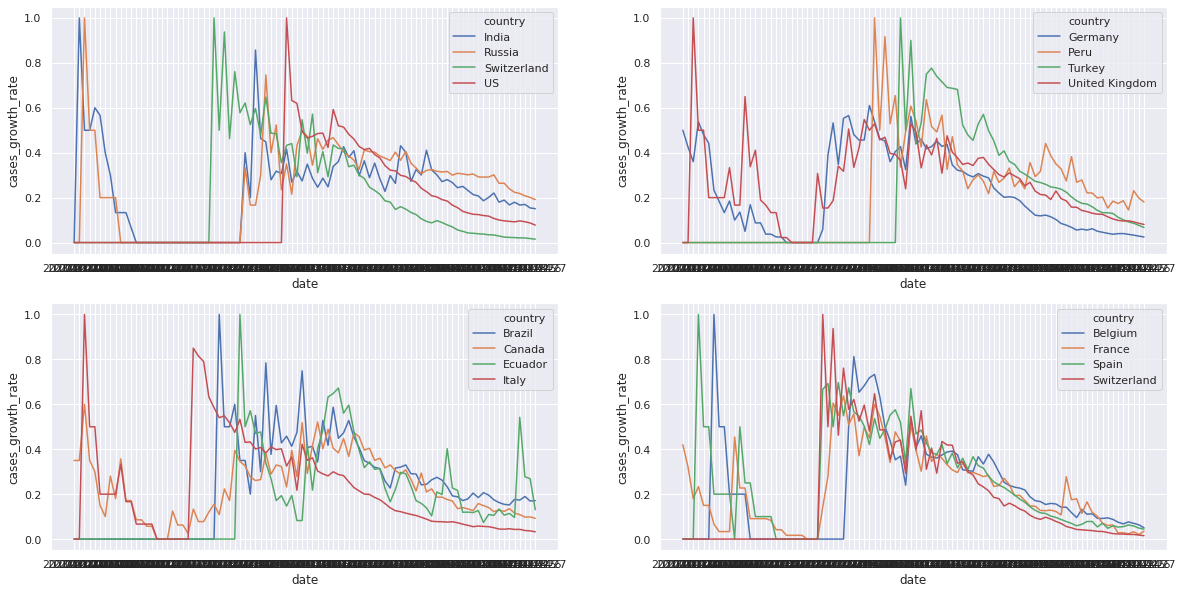

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.lineplot(x='date', y='cases_growth_rate', hue='country', 
             data=top_20_train[top_20_train.country.isin(['US', 'Russia', 'India', 'Switzerland'])], ax=ax[0][0])
sns.lineplot(x='date', y='cases_growth_rate', hue='country', 
             data=top_20_train[top_20_train.country.isin(['Peru', 'Turkey', 'United Kingdom', 'Germany'])], ax=ax[0][1])
sns.lineplot(x='date', y='cases_growth_rate', hue='country', 
             data=top_20_train[top_20_train.country.isin(['Ecuador', 'Brazil', 'Canada', 'Italy'])], ax=ax[1][0])
sns.lineplot(x='date', y='cases_growth_rate', hue='country', 
             data=top_20_train[top_20_train.country.isin(['France', 'Belgium', 'Spain', 'Switzerland'])], ax=ax[1][1])


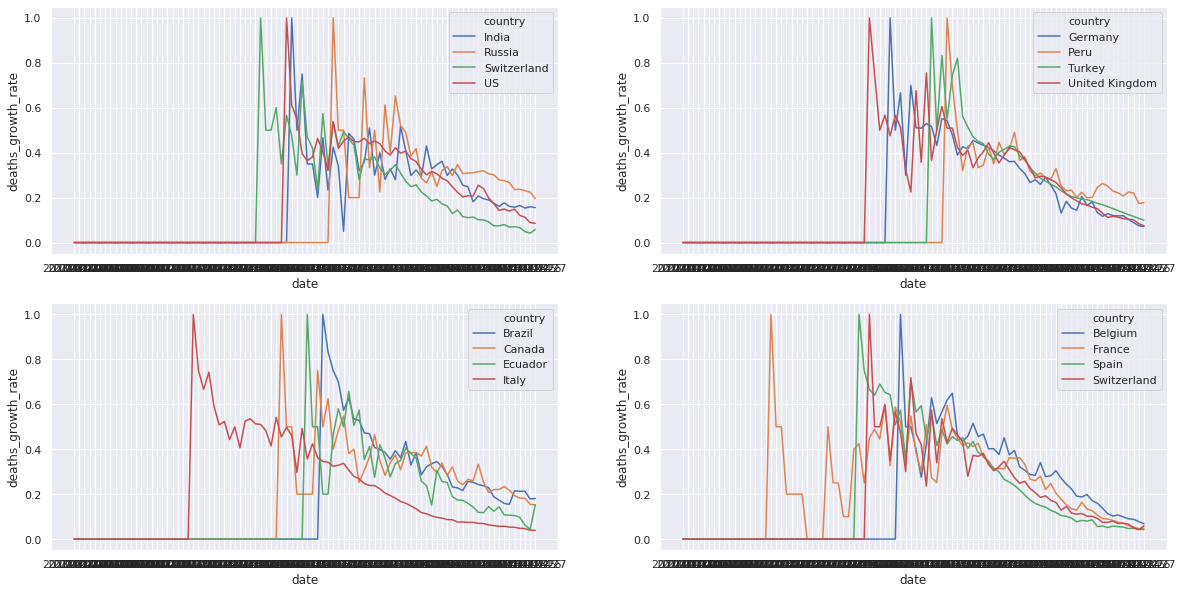

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.lineplot(x='date', y='deaths_growth_rate', hue='country', 
             data=top_20_train[top_20_train.country.isin(['US', 'Russia', 'India', 'Switzerland'])], ax=ax[0][0])
sns.lineplot(x='date', y='deaths_growth_rate', hue='country', 
             data=top_20_train[top_20_train.country.isin(['Peru', 'Turkey', 'United Kingdom', 'Germany'])], ax=ax[0][1])
sns.lineplot(x='date', y='deaths_growth_rate', hue='country', 
             data=top_20_train[top_20_train.country.isin(['Ecuador', 'Brazil', 'Canada', 'Italy'])], ax=ax[1][0])
sns.lineplot(x='date', y='deaths_growth_rate', hue='country', 
             data=top_20_train[top_20_train.country.isin(['France', 'Belgium', 'Spain', 'Switzerland'])], ax=ax[1][1])

## USA Analysis

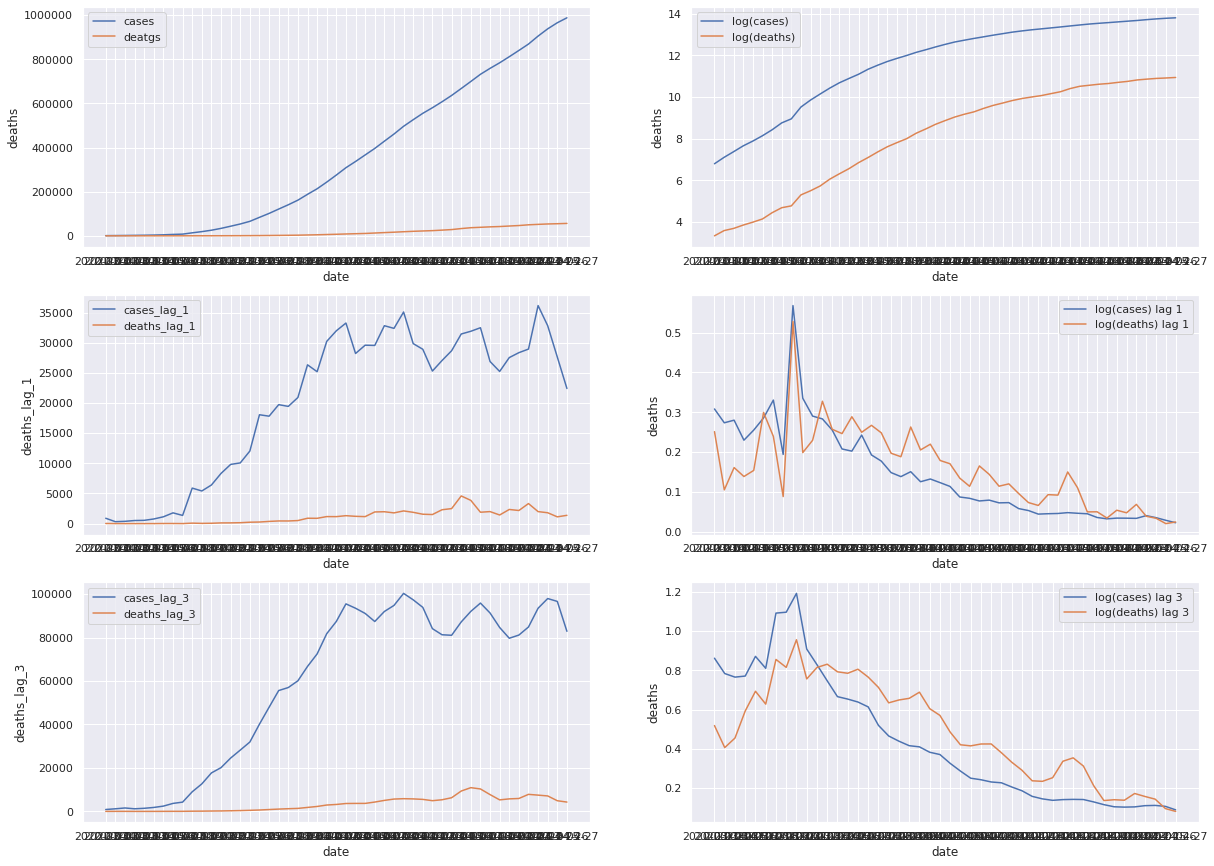

In [18]:
usa_data = top_20_train[top_20_train.country=='US']
usa_data = usa_data[usa_data.cases!=0]
usa_data.reset_index(inplace=True, drop=True)

fig, ax  = plt.subplots(3, 2, figsize=(20, 15))
sns.lineplot(x='date', y='cases', data=usa_data, ax=ax[0][0], label='cases')
sns.lineplot(x='date', y='deaths', data=usa_data, ax=ax[0][0], label='deatgs')
sns.lineplot(x=usa_data.date, y=np.log(usa_data.cases), ax=ax[0][1], label='log(cases)')
sns.lineplot(x=usa_data.date, y=np.log(usa_data.deaths), ax=ax[0][1], label='log(deaths)')
sns.lineplot(x='date', y='cases_lag_1', data=usa_data, ax=ax[1][0], label='cases_lag_1')
sns.lineplot(x='date', y='deaths_lag_1', data=usa_data, ax=ax[1][0], label='deaths_lag_1')
sns.lineplot(x=usa_data.date, y=np.log(usa_data.cases).diff(1), ax=ax[1][1], label='log(cases) lag 1')
sns.lineplot(x=usa_data.date, y=np.log(usa_data.deaths).diff(1), ax=ax[1][1], label='log(deaths) lag 1')
sns.lineplot(x='date', y='cases_lag_3', data=usa_data, ax=ax[2][0], label='cases_lag_3')
sns.lineplot(x='date', y='deaths_lag_3', data=usa_data, ax=ax[2][0], label='deaths_lag_3')
sns.lineplot(x=usa_data.date, y=np.log(usa_data.cases).diff(3), ax=ax[2][1], label='log(cases) lag 3')
sns.lineplot(x=usa_data.date, y=np.log(usa_data.deaths).diff(3), ax=ax[2][1], label='log(deaths) lag 3')

## Time series Analysis

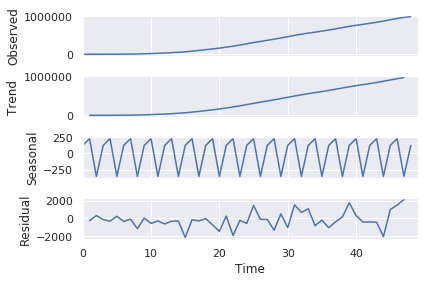

p-value of usa_data cases: 0.9944122509703998


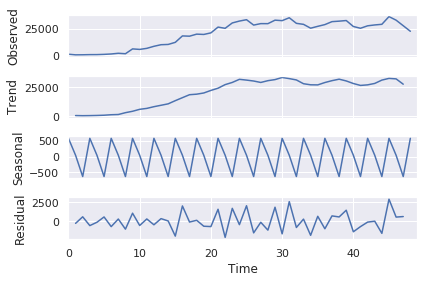

p-value of usa_data cases lag 1: 0.16392225824755408


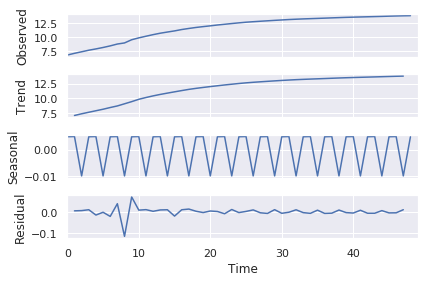

p-value of usa_data log cases: 0.08207227977106263


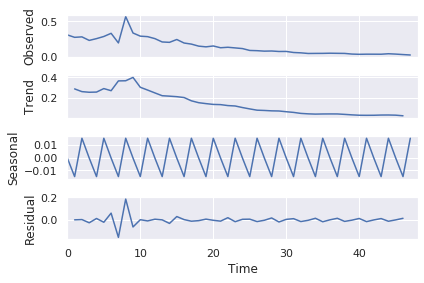

p-value of usa_data log cases lag 1: 2.8465991140799497e-07


In [19]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

results = sm.tsa.seasonal_decompose(usa_data["cases"].values, freq=3)
fig = results.plot()
plt.show()
adf = adfuller(usa_data["cases"].values)
print(f"p-value of usa_data cases: {adf[1]}")

results = sm.tsa.seasonal_decompose(usa_data["cases_lag_1"].values, freq=3)
fig = results.plot()
plt.show()
adf = adfuller(usa_data["cases_lag_1"].values)
print(f"p-value of usa_data cases lag 1: {adf[1]}")

cases_log_series = pd.Series(np.log(usa_data["cases"].values))
usa_data['log_cases'] = np.log(usa_data["cases"].values)

results = sm.tsa.seasonal_decompose(cases_log_series.values, freq=3)
fig = results.plot()
plt.show()
adf = adfuller(cases_log_series.values)
print(f"p-value of usa_data log cases: {adf[1]}")

results = sm.tsa.seasonal_decompose(cases_log_series.diff().dropna().values, freq=3)
fig = results.plot()
plt.show()
adf = adfuller(cases_log_series.diff().dropna().values)
print(f"p-value of usa_data log cases lag 1: {adf[1]}")

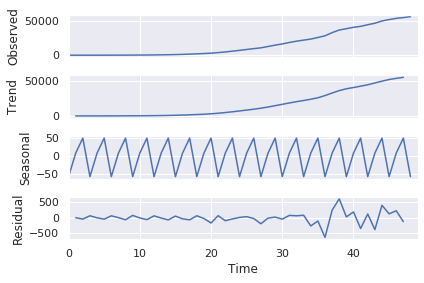

p-value of usa_data deaths: 0.19952940280606296


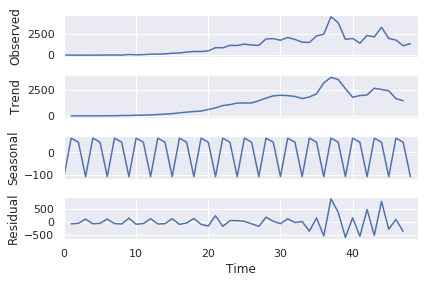

p-value of usa_data deaths lag 1: 0.9534486171741119


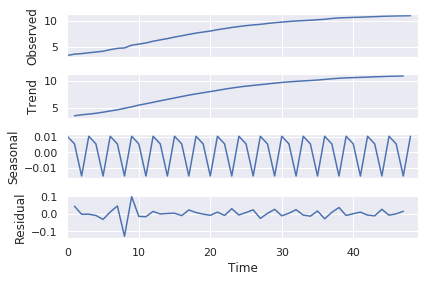

p-value of usa_data log deaths: 5.135300705109791e-17


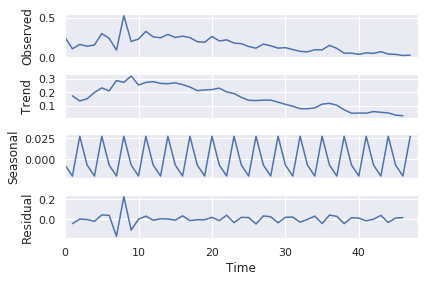

p-value of usa_data log deaths lag 1: 0.3205731663773611


In [20]:
results = sm.tsa.seasonal_decompose(usa_data["deaths"].values, freq=3)
fig = results.plot()
plt.show()
adf = adfuller(usa_data["deaths"].values)
print(f"p-value of usa_data deaths: {adf[1]}")

results = sm.tsa.seasonal_decompose(usa_data["deaths_lag_1"].values, freq=3)
fig = results.plot()
plt.show()
adf = adfuller(usa_data["deaths_lag_1"].values)
print(f"p-value of usa_data deaths lag 1: {adf[1]}")

deaths_log_series = pd.Series(np.log(usa_data["deaths"].values))
usa_data['log_deaths'] = np.log(usa_data["deaths"].values)

results = sm.tsa.seasonal_decompose(deaths_log_series.values, freq=3)
fig = results.plot()
plt.show()
adf = adfuller(deaths_log_series.values)
print(f"p-value of usa_data log deaths: {adf[1]}")

results = sm.tsa.seasonal_decompose(deaths_log_series.diff().dropna().values, freq=3)
fig = results.plot()
plt.show()
adf = adfuller(deaths_log_series.diff().dropna().values)
print(f"p-value of usa_data log deaths lag 1: {adf[1]}")

### Split data into training and validation

In [21]:
train_usa = usa_data[usa_data.date < '2020-04-22']
validation_usa = usa_data[usa_data.date >= '2020-04-22']

## ARIMA Model

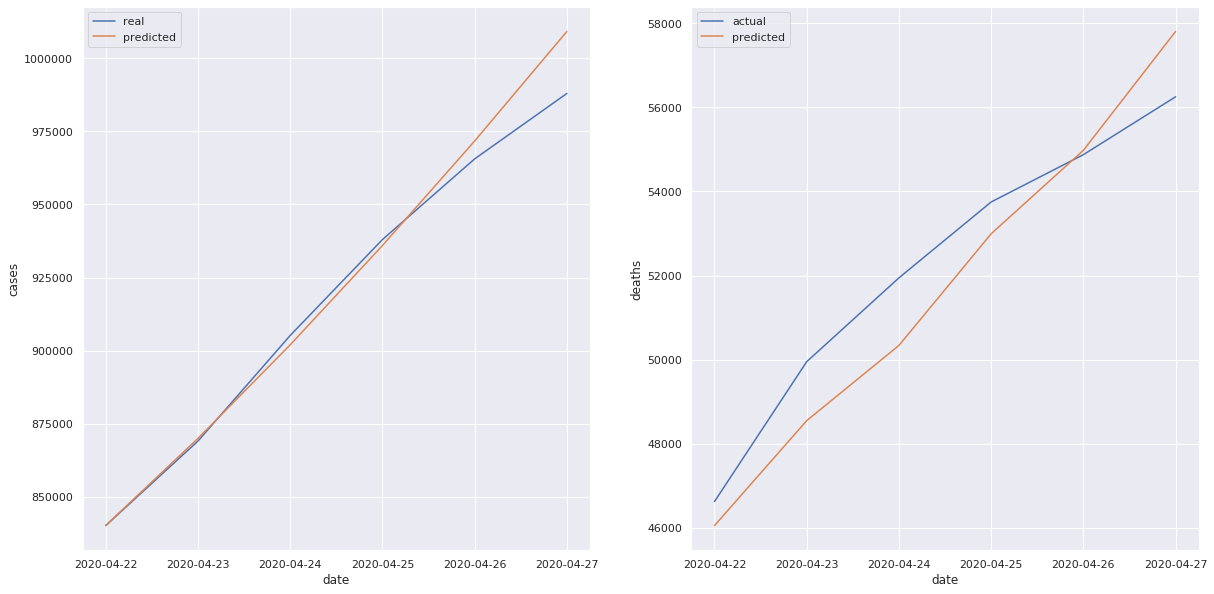

In [22]:
from statsmodels.tsa.arima_model import ARIMA

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

cases_log_series = np.log(train_usa["cases"].values)
sns.lineplot(x='date', y='cases', data=validation_usa, ax=ax[0], label='real')
cases_ar_pred = ARIMA(cases_log_series, (2, 1, 3)).fit().forecast(validation_usa['cases'].shape[0])
validation_usa['arima_pred_cases'] = np.exp(cases_ar_pred[0])
sns.lineplot(x=validation_usa['date'], y=np.exp(cases_ar_pred[0]), ax=ax[0], label='predicted')

deaths_log_series = np.log(train_usa["deaths"].values)
sns.lineplot(x='date', y='deaths', data=validation_usa, ax=ax[1], label='actual')
deaths_ar_pred = ARIMA(deaths_log_series, (3, 0, 0)).fit().forecast(validation_usa['deaths'].shape[0])
validation_usa['arima_pred_deaths'] = np.exp(deaths_ar_pred[0])
sns.lineplot(x=validation_usa['date'], y=np.exp(deaths_ar_pred[0]), ax=ax[1], label='predicted')

## Linear Models

In [23]:
from sklearn.preprocessing import LabelEncoder
date_encoder = LabelEncoder().fit(usa_data['date'])
train_usa['date_encoded'] = date_encoder.transform(train_usa['date'])
validation_usa['date_encoded'] = date_encoder.transform(validation_usa['date'])
usa_data['date_encoded'] = date_encoder.transform(usa_data['date'])

In [24]:
def update_shifts(data):
    data.sort_values(['country', 'date'])
    lags = [1, 3, 7]
    for lag in lags:
        data[f'cases_lag_{lag}'] = data['cases'].diff(lag)
        data[f'deaths_lag_{lag}'] = data['deaths'].diff(lag)
        data[f'cases_shifted_{lag}'] = data['cases'].shift(lag)
        data[f'deaths_shifted_{lag}'] = data['deaths'].shift(lag)

In [25]:
from sklearn.linear_model import LinearRegression

usa_data_copy = usa_data.copy()

cases_linear_model = LinearRegression().fit(
    train_usa[['date_encoded', 'cases_shifted_1', 'cases_shifted_3', 'cases_shifted_7']].values, train_usa['cases'])
deaths_linear_model = LinearRegression().fit(
    train_usa[['date_encoded', 'deaths_shifted_1', 'deaths_shifted_3', 'deaths_shifted_7']].values, train_usa['deaths'])


for date in validation_usa.date_encoded.unique():
    row = usa_data_copy[usa_data_copy.date_encoded==date]
    cases_pred = cases_linear_model.predict(
        row[['date_encoded', 'cases_shifted_1', 'cases_shifted_3', 'cases_shifted_7']].values)
    usa_data_copy.at[row.index, 'cases'] = cases_pred[0]
    deaths_pred = deaths_linear_model.predict(
        row[['date_encoded', 'deaths_shifted_1', 'deaths_shifted_3', 'deaths_shifted_7']].values)
    usa_data_copy.at[row.index, 'deaths'] = deaths_pred[0]
    update_shifts(usa_data_copy)
    
validation_usa['linear_pred_cases'] = usa_data_copy['cases']
validation_usa['linear_pred_deaths'] = usa_data_copy['deaths']

### Ridge Regression

In [26]:
from sklearn.linear_model import Ridge

usa_data_copy = usa_data.copy()

cases_linear_model = Ridge().fit(
    train_usa[['date_encoded', 'cases_shifted_1', 'cases_shifted_3', 'cases_shifted_7']].values, train_usa['cases'])
deaths_linear_model = Ridge().fit(
    train_usa[['date_encoded', 'deaths_shifted_1', 'deaths_shifted_3', 'deaths_shifted_7']].values, train_usa['deaths'])


for date in validation_usa.date_encoded.unique():
    row = usa_data_copy[usa_data_copy.date_encoded==date]
    cases_pred = cases_linear_model.predict(
        row[['date_encoded', 'cases_shifted_1', 'cases_shifted_3', 'cases_shifted_7']].values)
    usa_data_copy.at[row.index, 'cases'] = cases_pred[0]
    deaths_pred = deaths_linear_model.predict(
        row[['date_encoded', 'deaths_shifted_1', 'deaths_shifted_3', 'deaths_shifted_7']].values)
    usa_data_copy.at[row.index, 'deaths'] = deaths_pred[0]
    update_shifts(usa_data_copy)
    
validation_usa['ridge_pred_cases'] = usa_data_copy['cases']
validation_usa['ridge_pred_deaths'] = usa_data_copy['deaths']

### Lasso Regression

In [27]:
from sklearn.linear_model import Lasso

usa_data_copy = usa_data.copy()

cases_linear_model = Lasso().fit(
    train_usa[['date_encoded', 'cases_shifted_1', 'cases_shifted_3', 'cases_shifted_7']].values, train_usa['cases'])
deaths_linear_model = Lasso().fit(
    train_usa[['date_encoded', 'deaths_shifted_1', 'deaths_shifted_3', 'deaths_shifted_7']].values, train_usa['deaths'])


for date in validation_usa.date_encoded.unique():
    row = usa_data_copy[usa_data_copy.date_encoded==date]
    cases_pred = cases_linear_model.predict(
        row[['date_encoded', 'cases_shifted_1', 'cases_shifted_3', 'cases_shifted_7']].values)
    usa_data_copy.at[row.index, 'cases'] = cases_pred[0]
    deaths_pred = deaths_linear_model.predict(
        row[['date_encoded', 'deaths_shifted_1', 'deaths_shifted_3', 'deaths_shifted_7']].values)
    usa_data_copy.at[row.index, 'deaths'] = deaths_pred[0]
    update_shifts(usa_data_copy)
    
validation_usa['lasso_pred_cases'] = usa_data_copy['cases']
validation_usa['lasso_pred_deaths'] = usa_data_copy['deaths']

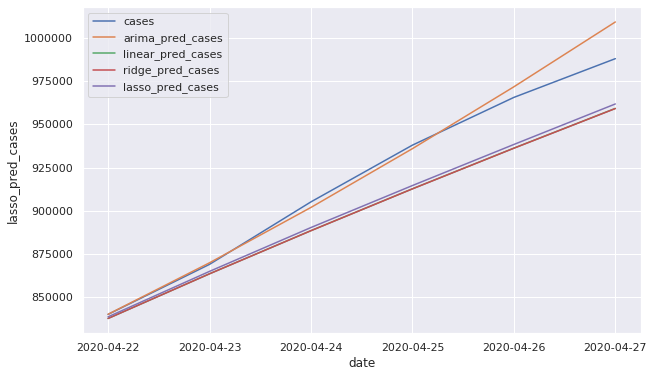

In [28]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='cases', data=validation_usa, label='cases')
sns.lineplot(x='date', y='arima_pred_cases', data=validation_usa, label='arima_pred_cases')
sns.lineplot(x='date', y='linear_pred_cases', data=validation_usa, label='linear_pred_cases')
sns.lineplot(x='date', y='ridge_pred_cases', data=validation_usa, label='ridge_pred_cases')
sns.lineplot(x='date', y='lasso_pred_cases', data=validation_usa, label='lasso_pred_cases')

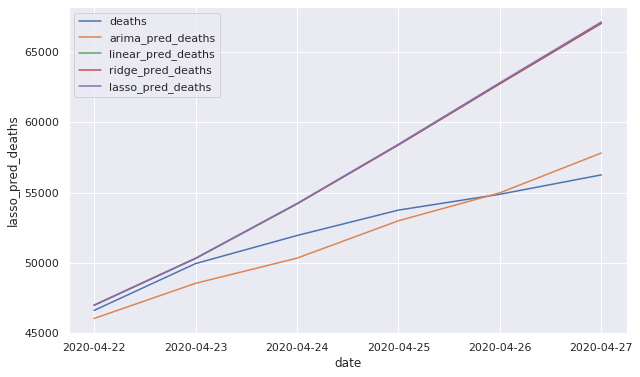

In [29]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='deaths', data=validation_usa, label='deaths')
sns.lineplot(x='date', y='arima_pred_deaths', data=validation_usa, label='arima_pred_deaths')
sns.lineplot(x='date', y='linear_pred_deaths', data=validation_usa, label='linear_pred_deaths')
sns.lineplot(x='date', y='ridge_pred_deaths', data=validation_usa, label='ridge_pred_deaths')
sns.lineplot(x='date', y='lasso_pred_deaths', data=validation_usa, label='lasso_pred_deaths')